In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from io import BytesIO
     

BASE_DIR = "./Cleaned Data/"
jaundiced_dir = os.path.join(BASE_DIR, "Jaundiced Eyes/")
normal_dir = os.path.join(BASE_DIR, "Normal Eyes/")

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(jaundiced_dir))} images of Jaundiced Eyes.")
print(f"There are {len(os.listdir(normal_dir))} images of Normal Eyes.")
     


There are 42 images of Jaundiced Eyes.
There are 280 images of Normal Eyes.


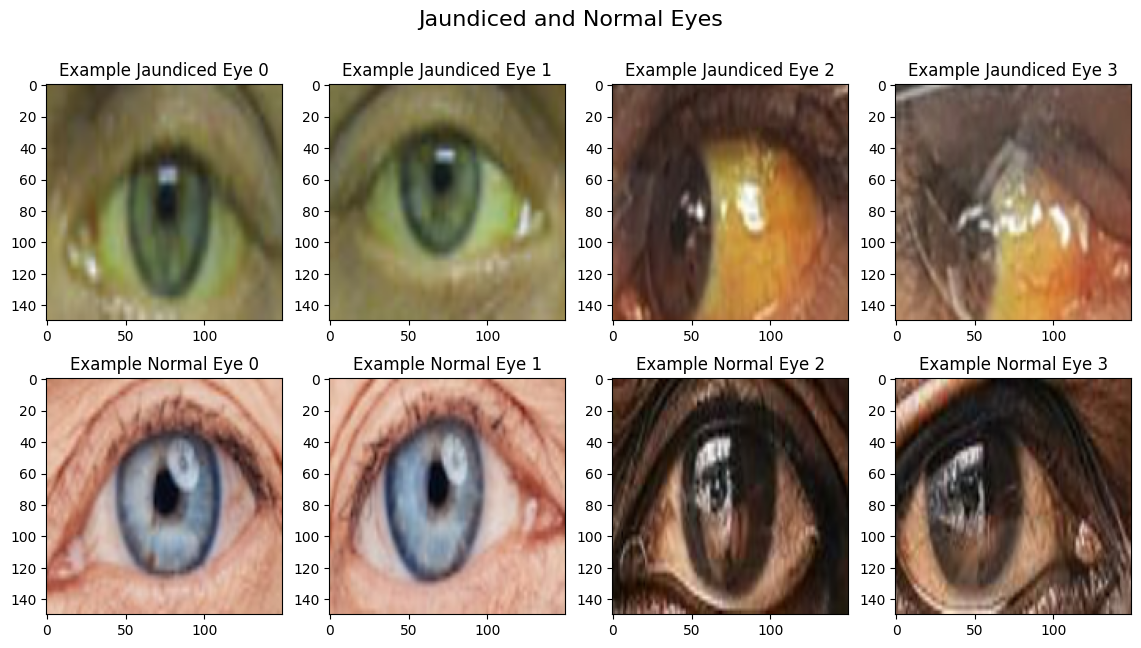

In [4]:
jaundiced_filenames = [os.path.join(jaundiced_dir, filename) for filename in os.listdir(jaundiced_dir)]
normal_filenames = [os.path.join(normal_dir, filename) for filename in os.listdir(normal_dir)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Jaundiced and Normal Eyes', fontsize=16)

# Plot the first 4 images of each class
for i, jaundiced_image in enumerate(jaundiced_filenames[:4]):
    img = tf.keras.utils.load_img(jaundiced_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Jaundiced Eye {i}')

for i, normal_image in enumerate(normal_filenames[:4]):
    img = tf.keras.utils.load_img(normal_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Normal Eye {i}')

plt.show()

In [5]:
def train_val_datasets():

    training_dataset, validation_dataset = tf.keras.utils.image_dataset_from_directory(
        directory=BASE_DIR,
        image_size=(150,150),
        batch_size=64,
        label_mode="binary",
        validation_split=0.20,
        subset="both",
        seed=42
    )


    return training_dataset, validation_dataset

training_dataset, validation_dataset = train_val_datasets()
     


Found 322 files belonging to 2 classes.
Using 258 files for training.
Using 64 files for validation.


In [6]:
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")
     


Maximum pixel value of images: 255.0

Shape of batch of images: (64, 150, 150, 3)
Shape of batch of labels: (64, 1)


In [7]:
def create_model():
    augmentation_layers = tf.keras.Sequential([
    tf.keras.Input(shape=(150,150,3)),
    tf.keras.layers.RandomFlip("vertikal"),
    tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode='nearest'),
    tf.keras.layers.RandomZoom(0.2, fill_mode='nearest'),
    ])

    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.004),
        metrics=['accuracy']
    )


    return model
     


In [8]:
model = create_model()
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")
     


predictions have shape: (64, 1)


In [ ]:
history = model.fit(
	training_dataset,
	epochs=20,
	validation_data=validation_dataset,
)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 550ms/step - accuracy: 0.7125 - loss: 1.8596 - val_accuracy: 0.1719 - val_loss: 7.6518
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 357ms/step - accuracy: 0.5821 - loss: 3.5392 - val_accuracy: 0.9062 - val_loss: 0.7730
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 358ms/step - accuracy: 0.8923 - loss: 1.2209 - val_accuracy: 0.7031 - val_loss: 1.1275
Epoch 4/20


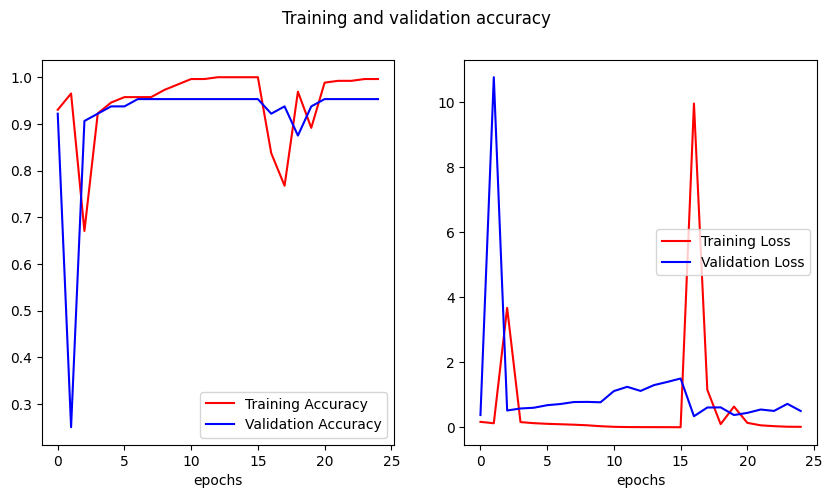

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [26]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

rescale_layer = tf.keras.layers.Rescaling(1./255)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0][0]

    with out:
        if prediction > 0.5:
            print(filename + " is a jaundiced eye")
        else:
            print(filename + " is a normal eye")


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""

    items = change.new
    for item in items: # Loop if there is more than one file uploaded
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)
uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()